## Squeezenet

    - https://github.com/DeepScale/SqueezeNet

In [3]:
import caffe
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import os

import importlib.machinery

In [4]:
modelpath = 'squeezenet_v1.0.caffemodel'
net_def = 'deploy.prototxt'

In [5]:
net = caffe.Net(net_def, modelpath, caffe.TEST)

In [5]:
# Use GPU
# caffe.set_device(0)
# caffe.set_mode_gpu()

In [6]:
# Image mean
mu = np.ndarray(3)
mu[0] = 104
mu[1] = 117
mu[2] = 123

# For caffenet
# mu = np.load('caffenet/ilsvrc_2012_mean.npy')
# mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values

print('mean-subtracted values:', zip('BGR', mu))

mean-subtracted values: <zip object at 0x00000169BEDE7048>


In [7]:
# Define image transformaer
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [8]:
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(10,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

# Load image
imgpath = 'cat_2.jpg'
image = caffe.io.load_image(imgpath)

D:\Program\miniconda3\lib\site-packages\skimage\io\_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Text(0.5,1,'cat_2.jpg')

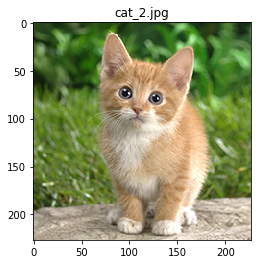

In [9]:
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
plt.title(imgpath)
# plt.imshow(transformed_image)

#### Inference

In [10]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
# %timeit output = net.forward()
output = net.forward()
output_prob = output['prob'][0].reshape(1000)  # the output probability vector for the first image in the batch

# print('Predicted class is:', output_prob.argmax())

In [12]:
# load ImageNet labels
labels_file = 'imagenet_class.txt'
if not os.path.exists(labels_file):
    print('\t Could not get class label...')
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

# print('Output label:', labels[output_prob.argmax()])

In [13]:
# Top-5 - sort top five predictions from softmax output
# reverse sort and take five largest items
top_inds = output_prob.reshape(len(output_prob)).argsort()[::-1][:5]

for k in range(5):
    idx = top_inds[k]
    print("Top %d: %d  %s  (%s, prob = %.6f)" % (k+1, idx, labels[idx][1], labels[idx][0], output_prob[idx]))
#     print('Probabilities and labels:', output_prob[top_inds[k]], labels[top_inds[k]][0], labels[top_inds[k]][1])

# print(top_inds)

Top 1: 282  tiger cat  (n02123159, prob = 0.169487)
Top 2: 331  hare  (n02326432, prob = 0.168492)
Top 3: 281  tabby, tabby cat  (n02123045, prob = 0.146051)
Top 4: 151  Chihuahua  (n02085620, prob = 0.123780)
Top 5: 278  kit fox, Vulpes macrotis  (n02119789, prob = 0.102415)


#### Draw network

In [13]:
loader = importlib.machinery.SourceFileLoader('draw_net', '../nn_draw_net.py')
handle = loader.load_module('draw_net')

handle.nn_save_net(open(net_def).read(), 'network.svg')

In [14]:
#from IPython.core.display import SVG, display
# %IPython.display inline
#SVG(url='D:/Users/kuriharat/Desktop/machinelearning/neuralnet/python/squeezenet/network.svg')

#### Network parameter

In [15]:
loader = importlib.machinery.SourceFileLoader('layer_info', '../nn_show_layer_info.py')
handle2 = loader.load_module('layer_info')

In [16]:
handle2.nn_show_layer_shape(net)

----- Layer shape -----
data     (10, 3, 227, 227)
conv1    (10, 96, 111, 111)
pool1    (10, 96, 55, 55)
fire2/squeeze1x1 (10, 16, 55, 55)
fire2/squeeze1x1_fire2/relu_squeeze1x1_0_split_0 (10, 16, 55, 55)
fire2/squeeze1x1_fire2/relu_squeeze1x1_0_split_1 (10, 16, 55, 55)
fire2/expand1x1 (10, 64, 55, 55)
fire2/expand3x3 (10, 64, 55, 55)
fire2/concat (10, 128, 55, 55)
fire3/squeeze1x1 (10, 16, 55, 55)
fire3/squeeze1x1_fire3/relu_squeeze1x1_0_split_0 (10, 16, 55, 55)
fire3/squeeze1x1_fire3/relu_squeeze1x1_0_split_1 (10, 16, 55, 55)
fire3/expand1x1 (10, 64, 55, 55)
fire3/expand3x3 (10, 64, 55, 55)
fire3/concat (10, 128, 55, 55)
fire4/squeeze1x1 (10, 32, 55, 55)
fire4/squeeze1x1_fire4/relu_squeeze1x1_0_split_0 (10, 32, 55, 55)
fire4/squeeze1x1_fire4/relu_squeeze1x1_0_split_1 (10, 32, 55, 55)
fire4/expand1x1 (10, 128, 55, 55)
fire4/expand3x3 (10, 128, 55, 55)
fire4/concat (10, 256, 55, 55)
pool4    (10, 256, 27, 27)
fire5/squeeze1x1 (10, 32, 27, 27)
fire5/squeeze1x1_fire5/relu_squeeze1x1_0_sp

In [17]:
handle2.nn_show_weight_info(net)

  Layer Name |           Weight |     Bias
conv1        |    (96, 3, 7, 7) |    (96,)
fire2/squeeze1x1 |   (16, 96, 1, 1) |    (16,)
fire2/expand1x1 |   (64, 16, 1, 1) |    (64,)
fire2/expand3x3 |   (64, 16, 3, 3) |    (64,)
fire3/squeeze1x1 |  (16, 128, 1, 1) |    (16,)
fire3/expand1x1 |   (64, 16, 1, 1) |    (64,)
fire3/expand3x3 |   (64, 16, 3, 3) |    (64,)
fire4/squeeze1x1 |  (32, 128, 1, 1) |    (32,)
fire4/expand1x1 |  (128, 32, 1, 1) |   (128,)
fire4/expand3x3 |  (128, 32, 3, 3) |   (128,)
fire5/squeeze1x1 |  (32, 256, 1, 1) |    (32,)
fire5/expand1x1 |  (128, 32, 1, 1) |   (128,)
fire5/expand3x3 |  (128, 32, 3, 3) |   (128,)
fire6/squeeze1x1 |  (48, 256, 1, 1) |    (48,)
fire6/expand1x1 |  (192, 48, 1, 1) |   (192,)
fire6/expand3x3 |  (192, 48, 3, 3) |   (192,)
fire7/squeeze1x1 |  (48, 384, 1, 1) |    (48,)
fire7/expand1x1 |  (192, 48, 1, 1) |   (192,)
fire7/expand3x3 |  (192, 48, 3, 3) |   (192,)
fire8/squeeze1x1 |  (64, 384, 1, 1) |    (64,)
fire8/expand1x1 |  (256, 64, 1, 1

In [18]:
handle2.nn_show_num_wight(net)

-------------- Num. of parameters -------------
Name     |   Weight + Bias
conv1    |    14112 +   96
fire2/squeeze1x1 |     1536 +   16
fire2/expand1x1 |     1024 +   64
fire2/expand3x3 |     9216 +   64
fire3/squeeze1x1 |     2048 +   16
fire3/expand1x1 |     1024 +   64
fire3/expand3x3 |     9216 +   64
fire4/squeeze1x1 |     4096 +   32
fire4/expand1x1 |     4096 +  128
fire4/expand3x3 |    36864 +  128
fire5/squeeze1x1 |     8192 +   32
fire5/expand1x1 |     4096 +  128
fire5/expand3x3 |    36864 +  128
fire6/squeeze1x1 |    12288 +   48
fire6/expand1x1 |     9216 +  192
fire6/expand3x3 |    82944 +  192
fire7/squeeze1x1 |    18432 +   48
fire7/expand1x1 |     9216 +  192
fire7/expand3x3 |    82944 +  192
fire8/squeeze1x1 |    24576 +   64
fire8/expand1x1 |    16384 +  256
fire8/expand3x3 |   147456 +  256
fire9/squeeze1x1 |    32768 +   64
fire9/expand1x1 |    16384 +  256
fire9/expand3x3 |   147456 +  256
conv10   |   512000 + 1000
TOTAL    |  1248424


#### Visualize 1st layer